In [1]:
import os
from os.path import join
import logging
import glob
import json
import pickle

import numpy as np
import astropy.io.fits as fits
from scipy.io import readsav

from PyReduce import util, echelle, instruments
from PyReduce.combine_frames import combine_bias, combine_flat
from PyReduce.continuum_normalization import splice_orders, continuum_normalize
from PyReduce.extract import extract
from PyReduce.normalize_flat import normalize_flat
from PyReduce.trace_orders import mark_orders
from PyReduce.wavelength_calibration import wavecal
from PyReduce.make_shear import make_shear

In [2]:
instrument = "UVES"
target = "HD132205"
steps = ("bias", "flat", "orders", "norm_flat", "wavecal", "science", "continuum")

base_dir = "./Test/"
mask_dir = "./masks"
input_dir = base_dir + "{instrument}/{target}/raw/{night}"
output_dir = base_dir + "{instrument}/{target}/reduced/{night}/Reduced_{mode}"

log_file = "logs/%s.log" % target
util.start_logging(log_file)

In [3]:
with open("settings_%s.json" % instrument.upper()) as f:
    config = json.load(f)
info = instruments.instrument_info.get_instrument_info(instrument)

config["plot"] = True

dates = input_dir.format(instrument=instrument, target=target, night="????-??-??")
dates = glob.glob(dates)
dates = [r for r in dates if os.path.isdir(r)]

# Only use the first observation night here
night = dates[0]
night = os.path.basename(night)

mode = "middle"

print("Instrument:", instrument)
print("Target:", target)
print("Observation Night:", night)
print("Instrument Mode:", mode)

Instrument: UVES
Target: HD132205
Observation Night: 2010-04-02
Instrument Mode: middle


In [4]:
input_dir = input_dir.format(instrument=instrument, target=target, night=night, mode=mode)
output_dir = output_dir.format(instrument=instrument, target=target, night=night, mode=mode)

files = glob.glob(os.path.join(input_dir, "%s.*.fits" % instrument))
files += glob.glob(os.path.join(input_dir, "%s.*.fits.gz" % instrument))
files = np.array(files)

f_bias, f_flat, f_wave, f_order, f_spec = instruments.instrument_info.sort_files(
            files, target, night, instrument, mode, **config
        )

# As we only have one science file here, we can ignore the dictionary
key = list(f_spec.keys())[0]
f_bias = f_bias[key]
f_flat = f_flat[key]
f_wave = f_wave[key]
f_order = f_order[key]
f_spec = f_spec[key]


print("Bias files: ", f_bias)
print("Flat files: ", f_flat)
print("Waveval files: ", f_wave)
print("Orderdef files: ", f_order)
print("Science files: ", f_spec)

Bias files:  ['./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T10_58_52.147.fits.gz'
 './Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T10_59_47.172.fits.gz'
 './Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T10_59_28.510.fits.gz'
 './Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T10_59_11.799.fits.gz'
 './Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T10_58_33.495.fits.gz']
Flat files:  ['./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_05_42.542.fits.gz'
 './Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_03_24.401.fits.gz'
 './Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_04_33.737.fits.gz'
 './Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_08_00.554.fits.gz'
 './Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_06_51.888.fits.gz']
Waveval files:  ['./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_09_23.851.fits.gz']
Orderdef files:  ['./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_02_16.644.fits.gz']
Science files:  ['./Test/

In [5]:
imode = util.find_first_index(info["modes"], mode)

# read configuration settings
extension = info["extension"][imode]
prefix = "%s_%s" % (instrument.lower(), mode.lower())
mask_file = join(mask_dir, "mask_%s_%s.fits.gz" % (instrument.lower(), mode))

# define intermediary product files
bias_file = join(output_dir, prefix + ".bias.fits")
flat_file = join(output_dir, prefix + ".flat.fits")
norm_flat_file = join(output_dir, prefix + ".flat_norm.fits")
blaze_file = join(output_dir, prefix + ".ord_norm.sav")
order_file = join(output_dir, prefix + ".ord_default.sav")

# create output folder structure if necessary
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [6]:
# Read mask
# the mask is not stored with the data files (it is not supported by astropy)
mask, _ = util.load_fits(mask_file, instrument, mode, extension=0)
mask = ~mask.data.astype(bool)  # REDUCE mask are inverse to numpy masks

WARNING - /home/ansgar/anaconda3/lib/python3.6/site-packages/astropy/io/fits/card.py:711: AstropyUserWarning: The following header keyword is invalid or follows an unrecognized non-standard convention:
OS-EXPOID=                5551          / OS expoId                             
  self._image), AstropyUserWarning)



INFO - Creating master bias
INFO - Files:
INFO - 0	./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T10_58_33.495.fits.gz
INFO - 1	./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T10_58_52.147.fits.gz
INFO - Files:
INFO - 0	./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T10_59_11.799.fits.gz
INFO - 1	./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T10_59_28.510.fits.gz
INFO - 2	./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T10_59_47.172.fits.gz
INFO - total cosmic ray hits identified and removed: 60
WARNING - /home/ansgar/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)

INFO - change in bias between image sets= -0.000504 electrons
INFO - measured background noise per image= 5.422997
INFO - background noise in combined image= 2.425238
INFO - fixing 8458 bad pixels


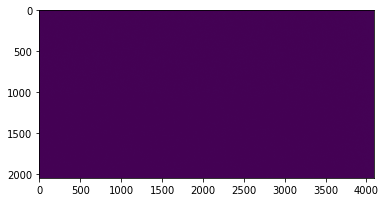

In [7]:
# Create master bias
if "bias" in steps or steps == "all":
    logging.info("Creating master bias")
    bias, bhead = combine_bias(
        f_bias,
        instrument,
        mode,
        mask=mask,
        extension=extension,
        plot=config.get("plot", False),
    )
    fits.writeto(bias_file, data=bias.data, header=bhead, overwrite=True)
else:
    logging.info("Loading master bias")
    bias = fits.open(bias_file)[0]
    bias, bhead = bias.data, bias.header
    bias = np.ma.masked_array(bias, mask=mask)

INFO - Creating master flat
INFO - Files:
INFO - 0	./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_05_42.542.fits.gz
INFO - 1	./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_03_24.401.fits.gz
INFO - 2	./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_04_33.737.fits.gz
INFO - 3	./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_08_00.554.fits.gz
INFO - 4	./Test/UVES/HD132205/raw/2010-04-02/UVES.2010-04-02T11_06_51.888.fits.gz
INFO - total cosmic ray hits identified and removed: 8358


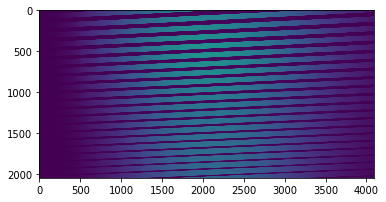

In [8]:
# Create master flat
if "flat" in steps or steps == "all":
    logging.info("Creating master flat")
    flat, fhead = combine_flat(
        f_flat,
        instrument,
        mode,
        mask=mask,
        extension=extension,
        bias=bias,
        plot=config.get("plot", False),
    )
    fits.writeto(flat_file, data=flat.data, header=fhead, overwrite=True)
else:
    logging.info("Loading master flat")
    flat = fits.open(flat_file)[0]
    flat, fhead = flat.data, flat.header
    flat = np.ma.masked_array(flat, mask=mask)

INFO - Tracing orders


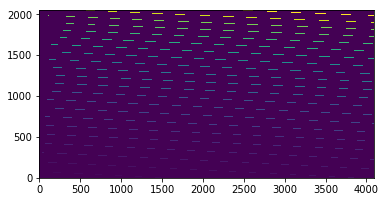

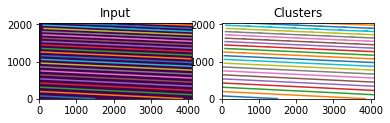

In [9]:
# Find default orders.
if "orders" in steps or steps == "all":
    logging.info("Tracing orders")

    order_img, _ = util.load_fits(
        f_order[0], instrument, mode, extension, mask=mask
    )

    orders, column_range = mark_orders(
        order_img,
        min_cluster=config.get("orders_threshold", 500),
        filter_size=config.get("orders_filter", 120),
        noise=config.get("orders_noise", 8),
        opower=config.get("orders_opower", 4),
        manual=config.get("orders_manual", True),
        plot=config.get("plot", True),
    )

    # Save results
    with open(order_file, "wb") as file:
        pickle.dump((orders, column_range), file)
else:
    logging.info("Loading order tracing data")
    with open(order_file, "rb") as file:
        orders, column_range = pickle.load(file)

INFO - Normalizing flat field


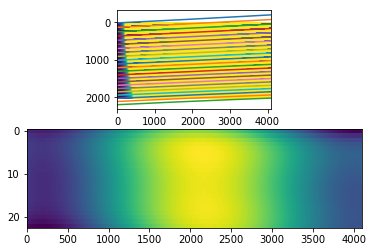

INFO - Using optimal extraction to produce spectrum
INFO - Extracting relative order 5 out of 22
INFO - Extracting relative order 10 out of 22
INFO - Extracting relative order 15 out of 22
WARNING - /home/ansgar/Documents/Python/PyReduce/extract.py:54: RuntimeWarning: divide by zero encountered in true_divide
  nimg = img / np.nansum(img, axis=1)[:, None]

WARNING - /home/ansgar/Documents/Python/PyReduce/extract.py:215: RuntimeWarning: divide by zero encountered in true_divide
  AX2.set_ylim((0, np.nanmax(di / np.nansum(di, axis=1)[:, None]) * 1.1))

INFO - Extracting relative order 20 out of 22


In [10]:
# = Construct normalized flat field.
if "norm_flat" in steps or steps == "all":
    logging.info("Normalizing flat field")
    order_range = (0, len(orders) - 1)

    flat, blaze = normalize_flat(
        flat,
        orders,
        gain=fhead["e_gain"],
        readnoise=fhead["e_readn"],
        dark=fhead["e_drk"],
        column_range=column_range,
        order_range=order_range,
        extraction_width=config.get("normflat_extraction_width", 0.2),
        degree=config.get("normflat_scatter_degree", 4),
        threshold=config.get("normflat_threshold", 10000),
        lambda_sf=config.get("normflat_lambda_sf", 8),
        lambda_sp=config.get("normflat_lambda_sp", 0),
        swath_width=config.get("normflat_swath_width", None),
        plot=config.get("plot", True),
    )

    # Save data
    with open(blaze_file, "wb") as file:
        pickle.dump(blaze, file)
    fits.writeto(norm_flat_file, data=flat.data, header=fhead, overwrite=True)
else:
    logging.info("Loading normalized flat field")
    flat = fits.open(norm_flat_file)[0]
    flat, fhead = flat.data, flat.header
    flat = np.ma.masked_array(flat, mask=mask)

    with open(blaze_file, "rb") as file:
        blaze = pickle.load(file)
        
# Fix column ranges
for i in range(blaze.shape[0]):
    column_range[i] = np.where(blaze[i] != 0)[0][[0, -1]]

INFO - Creating wavelength calibration
INFO - Using arc extraction to produce spectrum.


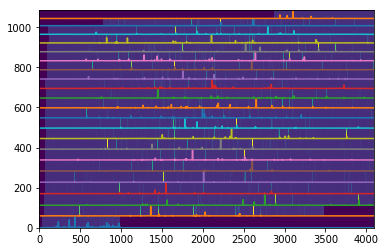

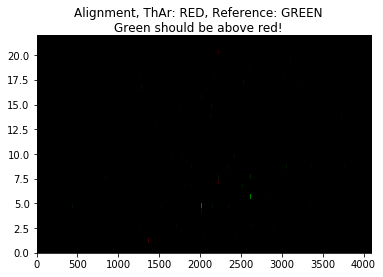

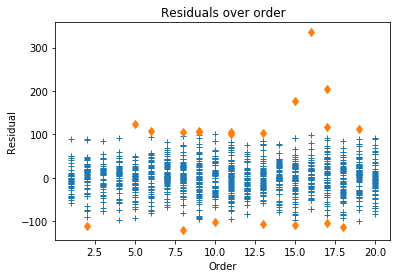

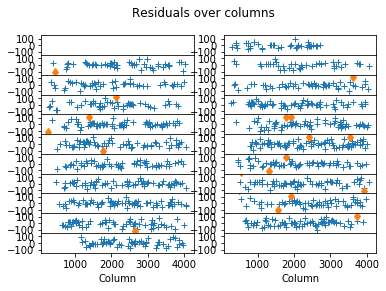

INFO - Number of lines used for wavelength calibration: 1179


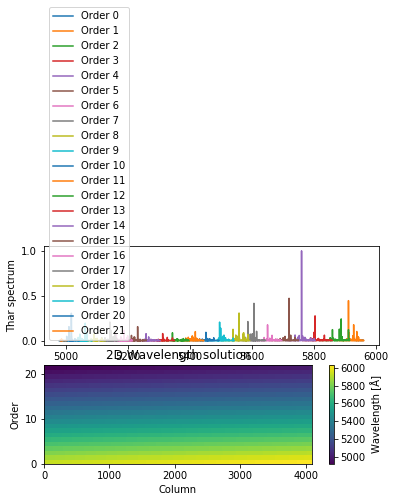

In [11]:
# Prepare wavelength calibration
if "wavecal" in steps or steps == "all":
    logging.info("Creating wavelength calibration")
    for f in f_wave:
        # Load wavecal image
        thar, thead = util.load_fits(f, instrument, mode, extension, mask=mask)
        orig = thar
        order_range = (0, len(orders) - 1)

        # Extract wavecal spectrum
        thar, _ = extract(
            thar,
            orders,
            gain=thead["e_gain"],
            readnoise=thead["e_readn"],
            dark=thead["e_drk"],
            extraction_type="arc",
            order_range=order_range,
            column_range=column_range,
            extraction_width=config.get("wavecal_extraction_width", 0.25),
            osample=config.get("wavecal_osample", 1),
            plot=config.get("plot", True),
        )
        thead["obase"] = (order_range[0], "base order number")

        # TODO: where to put this?
        # shear = make_shear(
        #     thar,
        #     orig,
        #     orders,
        #     extraction_width=config.get("wavecal_extraction_width", 0.25),
        #     column_range=column_range,
        #     plot=config.get("plot", True),
        # )
        shear = np.zeros_like(thar)

        # Create wavelength calibration fit
        # TODO just save the coefficients?
        reference = instruments.instrument_info.get_wavecal_filename(thead, instrument, mode)
        reference = readsav(reference)
        cs_lines = reference["cs_lines"]
        wave = wavecal(
            thar,
            cs_lines,
            plot=config.get("plot", True),
            manual=config.get("wavecal_manual", False),
        )

        nameout = util.swap_extension(f, ".thar.ech", output_dir)
        echelle.save(nameout, thead, spec=thar, wave=wave, shear=shear)
else:
    fname = util.swap_extension(f_wave[-1], ".thar.ech", output_dir)
    thar = echelle.read(fname, raw=True)
    wave = thar.wave
    shear = thar.shear

In [12]:
# Prepare for science spectra extraction
if "science" in steps or steps == "all":
    logging.info("Extracting science spectra")
    for f in f_spec:
        im, head = util.load_fits(
            f, instrument, mode, extension, mask=mask, dtype=np.float32
        )
        # Correct for bias and flat field
        im -= bias
        im /= flat

        order_range = (0, len(orders) - 1)

        # Optimally extract science spectrum
        spec, sigma = extract(
            im,
            orders,
            shear=shear,
            gain=head["e_gain"],
            readnoise=head["e_readn"],
            dark=head["e_drk"],
            column_range=column_range,
            order_range=order_range,
            extraction_width=config.get("science_extraction_width", 25),
            lambda_sf=config.get("science_lambda_sf", 0.1),
            lambda_sp=config.get("science_lambda_sp", 0),
            osample=config.get("science_osample", 1),
            swath_width=config.get("science_swath_width", 300),
            plot=config.get("plot", True),
        )
        head["obase"] = (order_range[0], " base order number")

        # save spectrum to disk
        nameout = util.swap_extension(f, ".science.ech", path=output_dir)
        echelle.save(nameout, head, spec=spec, sig=sigma)
else:
    f = f_spec[-1]
    fname = util.swap_extension(f, ".science.ech", path=output_dir)
    science = echelle.read(fname, raw=True)
    head = science.head
    spec = science.spec
    sigma = science.sig


INFO - Extracting science spectra
INFO - Using optimal extraction to produce spectrum
INFO - Extracting relative order 5 out of 22
INFO - Extracting relative order 10 out of 22
INFO - Extracting relative order 15 out of 22
INFO - Extracting relative order 20 out of 22


INFO - Continuum normalization
INFO - Splicing orders


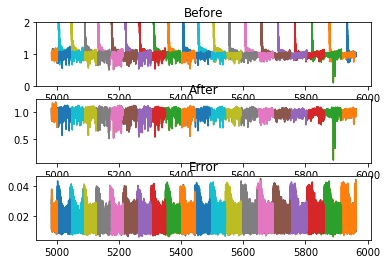

In [13]:
if "continuum" in steps or steps == "all":
    logging.info("Continuum normalization")
    for f in f_spec:
        # fix column ranges
        for i in range(spec.shape[0]):
            column_range[i] = np.where(spec[i] != 0)[0][[0, -1]] + [0, 1]

        logging.info("Splicing orders")
        spec, wave, blaze, sigma = splice_orders(
            spec,
            wave,
            blaze,
            sigma,
            column_range=column_range,
            scaling=True,
            plot=config.get("plot", True),
        )

        #spec = continuum_normalize(spec, wave, blaze, sigma)

In [14]:
# Combine science with wavecal and continuum
for f in f_spec:
    head["e_error_scale"] = "absolute"

    rv_corr, bjd = util.helcorr(head["e_obslon"], head["e_obslat"], head["e_obsalt"], head["ra"], head["dec"], head["e_jd"])
    head["barycorr"] = rv_corr
    head["e_jd"] = bjd

    fname = "{instrument}.{night}.ech".format(instrument=instrument.upper(), night=night)
    fname = os.path.join(output_dir, fname)
    echelle.save(
        fname,
        head,
        spec=spec,
        sig=sigma,
        cont=blaze,
        wave=wave,
        columns=column_range,
    )
    logging.info("science file: %s", os.path.basename(fname))
    logging.debug("--------------------------------")

WARNING - /home/ansgar/anaconda3/lib/python3.6/site-packages/astropy/io/fits/card.py:266: VerifyWarning: Keyword name 'e_error_scale' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  keyword), VerifyWarning)

INFO - science file: UVES.2010-04-02.ech


In [15]:
%tb


No traceback available to show.
